In [23]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [24]:
transform3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize first (required for some augmentations)
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),  # Spatial augmentations
    transforms.ColorJitter(hue=0.05, saturation=0.05),  # Color augmentations
    transforms.RandomHorizontalFlip(),  # Flip augmentation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),  # Optional blur
    transforms.ToTensor(),  # Convert to tensor (normalized to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet stats
])

In [25]:
dataset_resnet=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform3)

In [26]:
indices=list(range(len(dataset_resnet))) # dataset ko numerate karne ke liye
split=int(np.floor(0.70*len(dataset_resnet)))
validation=int(np.floor(0.60*split))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%

print(f"length of train size : {validation}")
print(f"length of validation size : {split-validation}")
print(f"length of test size : {len(dataset_resnet)-split}")

np.random.shuffle(indices) # dataset me randomness laane ke liye

# ab actual splitting
train_indices, validation_indices, test_indices = (
    indices[:validation], # [:5]->0,1,2,3,4
    indices[validation:split],# [1:3]->1,2
    indices[split:],# [2:]-> 2,3,4,5,........
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


length of train size : 1585
length of validation size : 1058
length of test size : 1134


In [27]:
targets_size = len(dataset_resnet.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_resnet.class_to_idx.keys()))
num_classes_list = list(dataset_resnet.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

In [28]:
model = models.resnet18(pretrained=True)
# model

In [29]:
n_features = model.conv1.in_channels #resnet18; number of input features in the first convolutional layer
n_features

3

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
# calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy
optimizer = torch.optim.Adam(model.parameters())
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

In [32]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=validation_sampler
)

In [34]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Training and Validation Losses', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [35]:
def batch_gd_new(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # Memory tracking initialization
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        mem_before = torch.cuda.memory_allocated() / 1024**2  # MB
    
    # Track average inference time
    total_inference_time = 0
    inference_count = 0
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.time()
            optimizer.zero_grad()
            output = model(inputs)
            inference_time = time.time() - start_time
            
            total_inference_time += inference_time
            inference_count += 1
            
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        test_loss = []
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                test_loss.append(loss.item())
        model.train()

        test_loss = np.mean(test_loss)
        train_losses[e] = train_loss
        test_losses[e] = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {e+1}/{epochs} Train loss: {train_loss:.4f} Val loss: {test_loss:.4f} Duration: {dt}")

    # Memory and timing results
    avg_inference_time = total_inference_time / inference_count if inference_count > 0 else 0
    print(f"\nTraining Summary:")
    print(f"Average inference time per batch: {avg_inference_time:.4f} seconds")
    
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1024**2
        mem_used = mem_after - mem_before
        print(f"GPU Memory used: {mem_used:.2f} MB")
    
    return train_losses, test_losses

Epoch 1/10 Train loss: 2.6257 Val loss: 2.0150 Duration: 0:01:13.399663
Epoch 2/10 Train loss: 0.6991 Val loss: 1.6052 Duration: 0:01:12.466982
Epoch 3/10 Train loss: 0.3753 Val loss: 0.8091 Duration: 0:01:11.910476
Epoch 4/10 Train loss: 0.2204 Val loss: 0.5985 Duration: 0:01:11.953974
Epoch 5/10 Train loss: 0.2347 Val loss: 0.7911 Duration: 0:01:12.235475
Epoch 6/10 Train loss: 0.2001 Val loss: 0.5930 Duration: 0:01:12.352939
Epoch 7/10 Train loss: 0.1328 Val loss: 0.4328 Duration: 0:01:11.750177
Epoch 8/10 Train loss: 0.1076 Val loss: 0.7383 Duration: 0:01:11.938448
Epoch 9/10 Train loss: 0.1807 Val loss: 1.2005 Duration: 0:01:11.610424
Epoch 10/10 Train loss: 0.1327 Val loss: 0.6143 Duration: 0:01:11.697711

Training Summary:
Average inference time per batch: 0.0050 seconds
GPU Memory used: 170.25 MB


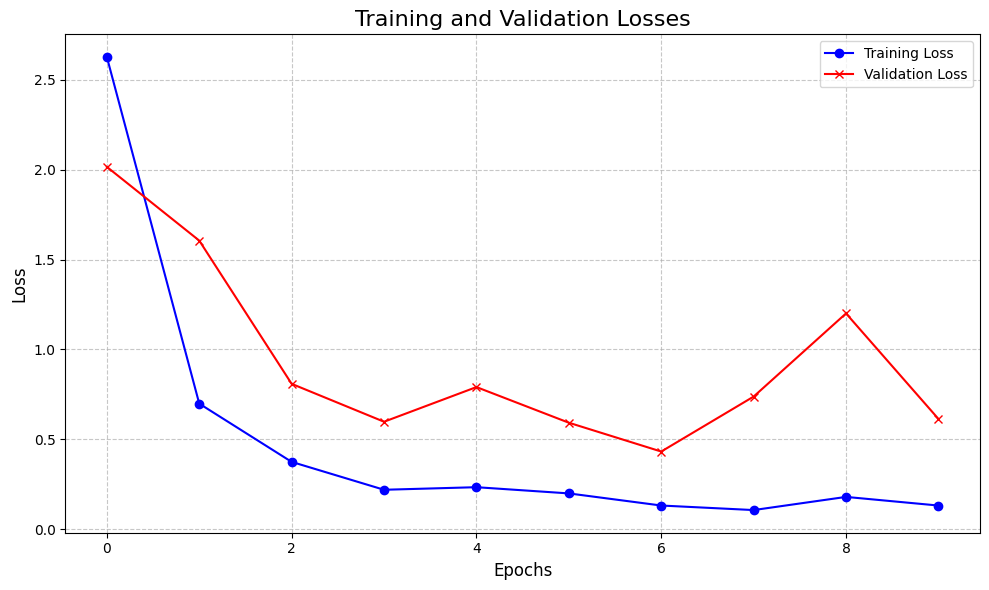

In [36]:
train_losses, test_losses= batch_gd_new(model, criterion, train_loader, validation_loader, 10)
plot_losses(train_losses, test_losses)

In [37]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        # print(outputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [38]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9640378548895899
Test Accuracy : 0.9065255731922398
Validation Accuracy : 0.8979206049149339
